In [1]:
pip install imantics

In [2]:
pip install colorama

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from PIL import Image
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
import re
%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [4]:
train_dir = '/content/drive/MyDrive/Childrens dental caries segmentation dataset/Train'
test_dir = '/content/drive/MyDrive/Childrens dental caries segmentation dataset/Test'
train_masks_dir = f'{train_dir}/annotations.json'
train_images_dir = f'{train_dir}/images'
test_masks_dir = f'{test_dir}/annotations.json'
test_images_dir = f'{test_dir}/images'

In [5]:
image_size = 512
input_image_size = (2000, 942)

In [6]:
train_images_listdir = os.listdir(train_images_dir)
test_images_listdir = os.listdir(test_images_dir)
print(f"{blk}Dataset contains {red}{len(train_images_listdir) + len(test_images_listdir)} {blk}images")

Dataset contains 100 images


In [7]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

In [8]:
train_annote = json.load(open(train_masks_dir))
test_annote = json.load(open(test_masks_dir))

In [9]:
train_id_to_images = {image['id']:image['file_name'] for image in train_annote['images']}
test_id_to_images = {image['id']:image['file_name'] for image in test_annote['images']}


In [10]:
first9images = train_images_listdir[:9]

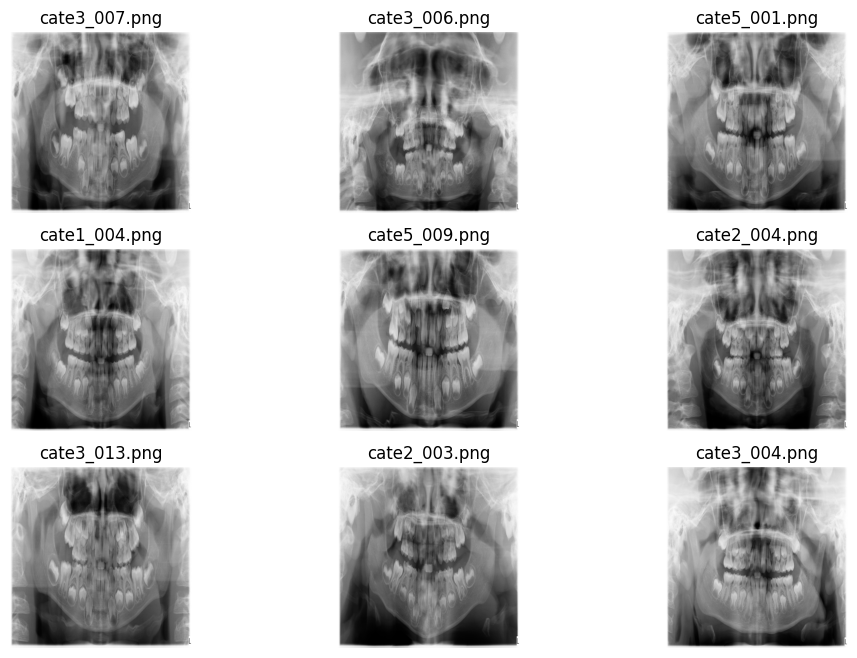

In [11]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (12,8))

for i, ax in enumerate(ax.flat):
    if i < len(first9images):
        img = read_image(f"{train_images_dir}/{first9images[i]}")
        ax.set_title(f"{first9images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [12]:
train_images = np.zeros((len(train_images_listdir), image_size, image_size, 3), dtype=np.uint8)

for image_id, image_filename in train_id_to_images.items():
    cur_image = read_image(f"{train_images_dir}/{image_filename}")
    train_images[image_id - 1] = cur_image

test_images = np.zeros((len(test_images_listdir), image_size, image_size, 3), dtype=np.uint8)

for image_id, image_filename in test_id_to_images.items():
    cur_image = read_image(f"{test_images_dir}/{image_filename}")
    test_images[image_id - 1] = cur_image

In [13]:
train_masks = np.zeros((len(train_images_listdir), image_size, image_size, 1), dtype=bool)

for annotation in train_annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)

    mask_index = image_id - 1
    train_masks[mask_index] = train_masks[mask_index] | cur_mask

In [14]:
test_masks = np.zeros((len(test_images_listdir), image_size, image_size, 1), dtype=bool)

for annotation in test_annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)

    mask_index = image_id - 1
    test_masks[mask_index] = test_masks[mask_index] | cur_mask

In [15]:
print(f"{blk}== Training set shapes == \n{blk}Images : {red}{train_images.shape}\n{blk}Masks : {red}{train_masks.shape}")
print(f"{blk}== Test set shapes == \n{blk}Images : {red}{test_images.shape}\n{blk}Masks : {red}{test_masks.shape}")

== Training set shapes == 
Images : (70, 512, 512, 3)
Masks : (70, 512, 512, 1)
== Test set shapes == 
Images : (30, 512, 512, 3)
Masks : (30, 512, 512, 1)


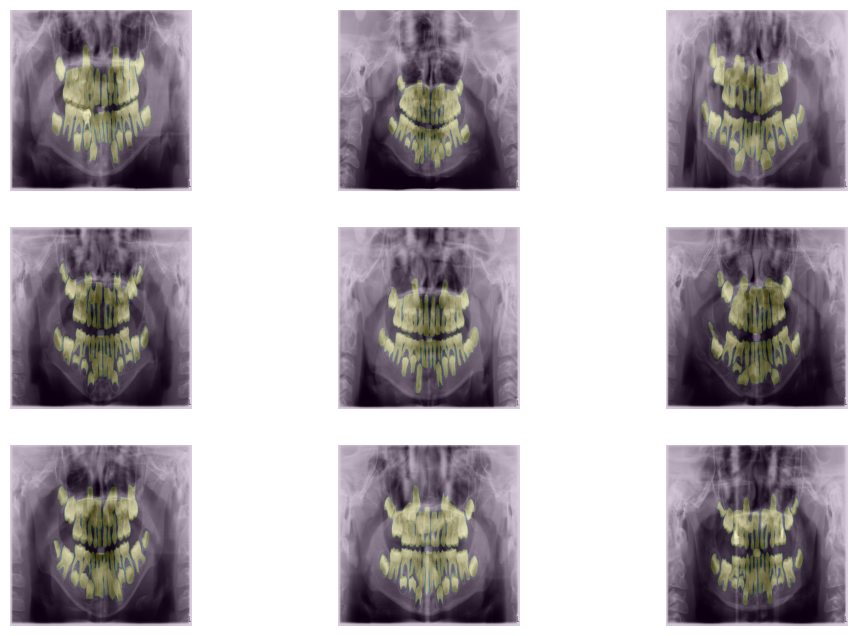

In [16]:
fig, ax = plt.subplots(rows, cols, figsize = (12,8))

for i, ax in enumerate(ax.flat):
    if i < 9:
        ax.imshow(train_images[i])
        ax.imshow(train_masks[i], alpha=0.2)
        ax.axis('off')

In [17]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512, 512, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [19]:
unet_result = unet_model.fit(train_images, train_masks, validation_split = 0.2, batch_size=4, epochs=20)

Epoch 1/20
14/14 [==============================] - 28s 295ms/step - loss: 0.3533 - accuracy: 0.8628 - val_loss: 1216.7550 - val_accuracy: 0.8344
Epoch 2/20
14/14 [==============================] - 2s 127ms/step - loss: 0.1755 - accuracy: 0.9377 - val_loss: 926.9228 - val_accuracy: 0.8383
Epoch 3/20
14/14 [==============================] - 2s 127ms/step - loss: 0.1441 - accuracy: 0.9468 - val_loss: 51.5084 - val_accuracy: 0.8383
Epoch 4/20
14/14 [==============================] - 2s 127ms/step - loss: 0.1256 - accuracy: 0.9530 - val_loss: 5.6675 - val_accuracy: 0.8383
Epoch 5/20
14/14 [==============================] - 2s 127ms/step - loss: 0.1152 - accuracy: 0.9560 - val_loss: 2.1967 - val_accuracy: 0.8380
Epoch 6/20
14/14 [==============================] - 2s 127ms/step - loss: 0.1119 - accuracy: 0.9565 - val_loss: 3.0473 - val_accuracy: 0.8383
Epoch 7/20
14/14 [==============================] - 2s 127ms/step - loss: 0.1016 - accuracy: 0.9598 - val_loss: 0.7398 - val_accuracy: 0.8388

In [20]:
unet_predict = unet_model.predict(test_images)


1/1 [==============================] - 17s 17s/step


In [24]:
unet_threshold = (unet_predict > 0.5).astype(np.uint8)

In [25]:
def show_result(og, unet, target):
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net")
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

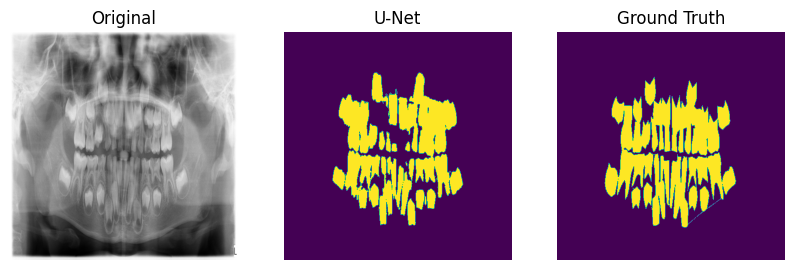

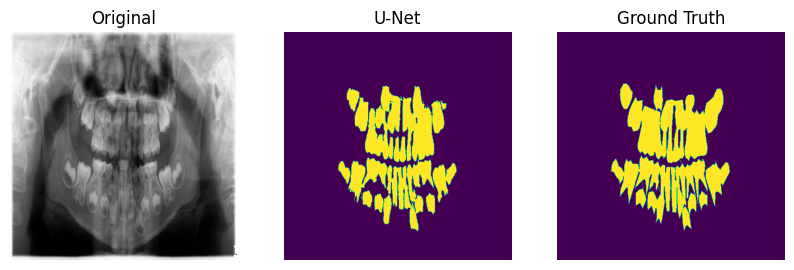

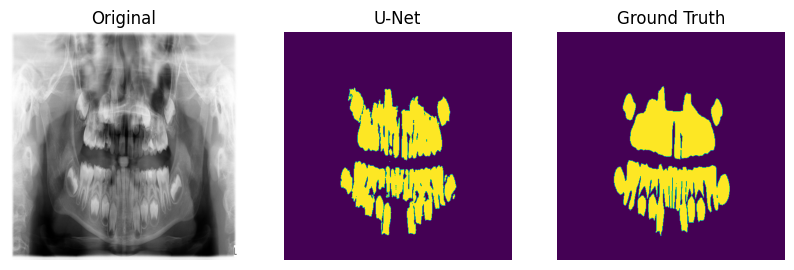

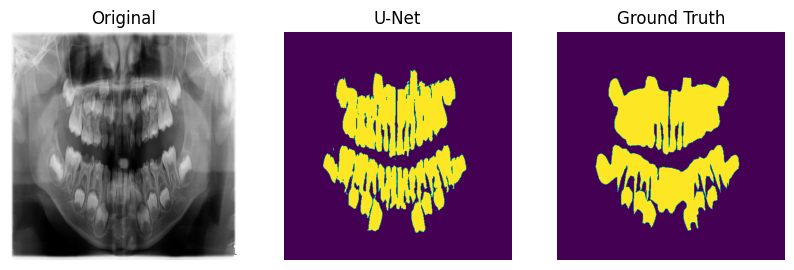

In [26]:
for i in range(4):
    show_result(test_images[i], unet_threshold[i], test_masks[i])